In [1]:
# Import Packages and Libraries needed for the project
import pandas as pd
import numpy as np

# for data processing
import requests
import json

# for Geospatial data
import geopandas as gpd 

# for Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
def a_load_data(url):
    # Load GeoPandas data from OpenData.Minneapolis.Gov API
    response = requests.get(url)
    data = json.loads(response.text)
    # since the data contains nested dictionaries we need to flatten the data from the outer features key
    data2 = pd.json_normalize(data['features'])
    # Rename the nested dictionary keys of geometry and  properties columns by removing geometry and properties.
    data2.columns = data2.columns.str.replace('geometry.', '')
    data2.columns = data2.columns.str.replace('properties.', '')
    return data2

In [3]:
# Office Conduct Data from Opendata.Minneapolis.Gov https://opendata.minneapolismn.gov/datasets/cityoflakes::officer-conduct-data/about
url="https://services.arcgis.com/afSMGVsC7QlRK1kZ/arcgis/rest/services/Officer_Conduct_Data/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson"
raw_data = a_load_data(url)
raw_data.head()

,type,id,geometry,Matter_Number,Short_Matter_Name,Law_Type_Description,Matter_Type_Description,Jurisdiction_Description,Civil_Process,DESCRIPTION,Incident_Date,Date_Opened,Date_Closed,Transaction_Date,Amount_Charged,ObjectId
0,Feature,1,None,01L-0003,"Gatlin, Juwan - Estate v. City of Minneapolis",Officer Conduct,Officer Conduct,Hennepin County District Court,LITIGATION,Lawsuit Settlement,902466000000,1138946400000,1.172556e+12,1181192400000,"40,000",1
1,Feature,2,None,02L-0218,"Scott, Timothy v. City of Minneapolis",Officer Conduct,Officer Conduct,U.S. District Court,LITIGATION,Lawsuit Settlement,890287200000,1138946400000,1.142921e+12,1139464800000,"5,000",2
2,Feature,3,None,03L-0296,"Robinson, Darryl Maurice",Officer Conduct,Officer Conduct,U.S. District Court,LITIGATION,Lawsuit Settlement,1000184400000,1138946400000,1.146719e+12,1137045600000,"49,900",3
3,Feature,4,None,03L-0296,"Robinson, Darryl Maurice",Officer Conduct,Officer Conduct,U.S. District Court,LITIGATION,Lawsuit Settlement,1000184400000,1138946400000,1.146719e+12,1140674400000,"150,000",4
4,Feature,5,None,03L-0319,"Ngo, Duy v. City of Minneapolis",Officer Conduct,Officer Conduct,U.S. District Court,LITIGATION,Lawsuit Settlement,1046152800000,1138946400000,1.198130e+12,1196402400000,"4,500,000",5


In [4]:
def b_clean_data(df):
    # convert unix time to datetime
    date_cols = ['Incident_Date','Date_Opened', 'Date_Closed', 'Transaction_Date']
    for col in date_cols:
        raw_data[col] = pd.to_datetime(raw_data[col], unit='ms')

    # Drop columns that are not needed as they all have the same value
    cols_not_needed = ['geometry', 'type', 'Law_Type_Description']
    
    df.drop(columns=cols_not_needed, inplace=True)
    
    # Drop rows with missing values
    df.dropna(inplace=True)
    
    # Convert object columns to numeric
    # remove commas from column
    df['Amount_Charged'] = df['Amount_Charged'].str.replace(',', '')
    df['Amount_Charged'] = df['Amount_Charged'].astype('float64')
    
    return df

In [5]:
df = b_clean_data(raw_data)
df.head()

,id,Matter_Number,Short_Matter_Name,Matter_Type_Description,Jurisdiction_Description,Civil_Process,DESCRIPTION,Incident_Date,Date_Opened,Date_Closed,Transaction_Date,Amount_Charged,ObjectId
0,1,01L-0003,"Gatlin, Juwan - Estate v. City of Minneapolis",Officer Conduct,Hennepin County District Court,LITIGATION,Lawsuit Settlement,1998-08-07 05:00:00,2006-02-03 06:00:00,2007-02-27 06:00:00,2007-06-07 05:00:00,40000.0,1
1,2,02L-0218,"Scott, Timothy v. City of Minneapolis",Officer Conduct,U.S. District Court,LITIGATION,Lawsuit Settlement,1998-03-19 06:00:00,2006-02-03 06:00:00,2006-03-21 06:00:00,2006-02-09 06:00:00,5000.0,2
2,3,03L-0296,"Robinson, Darryl Maurice",Officer Conduct,U.S. District Court,LITIGATION,Lawsuit Settlement,2001-09-11 05:00:00,2006-02-03 06:00:00,2006-05-04 05:00:00,2006-01-12 06:00:00,49900.0,3
3,4,03L-0296,"Robinson, Darryl Maurice",Officer Conduct,U.S. District Court,LITIGATION,Lawsuit Settlement,2001-09-11 05:00:00,2006-02-03 06:00:00,2006-05-04 05:00:00,2006-02-23 06:00:00,150000.0,4
4,5,03L-0319,"Ngo, Duy v. City of Minneapolis",Officer Conduct,U.S. District Court,LITIGATION,Lawsuit Settlement,2003-02-25 06:00:00,2006-02-03 06:00:00,2007-12-20 06:00:00,2007-11-30 06:00:00,4500000.0,5


In [6]:
# Test if the 'Short_Matter_Name' column contains "v."
#contains_v = df['Short_Matter_Name'].str.contains('v.')

df['Officer_Name'] = df['Short_Matter_Name'].str.split('v.').str[0]
df[['Officer_Name', 'Short_Matter_Name']].head()

,Officer_Name,Short_Matter_Name
0,"Gatlin, Juwan - Estate","Gatlin, Juwan - Estate v. City of Minneapolis"
1,"Scott, Timothy","Scott, Timothy v. City of Minneapolis"
2,"Robinson, Darryl Maurice","Robinson, Darryl Maurice"
3,"Robinson, Darryl Maurice","Robinson, Darryl Maurice"
4,"Ngo, Duy","Ngo, Duy v. City of Minneapolis"


In [7]:
def c_feature_engineering(df):
    
    # Extract Officer Name from the Short_Matter_Name column
    df['Officer_Name'] = df['Short_Matter_Name'].str.split('v.').str[0]
    
    # Create a new column called 'Case+Duration' to calculate the number of days it took to close a case
    df['Case_Duration'] = (df['Date_Closed'] - df['Date_Opened']).dt.days
    
    # Create a new column called 'Duration' to calculate the number of days it took to close a case from the Incident_Date column
    df['Case_Duration'] = (df['Date_Closed'] - df['Incident_Date']).dt.days
    
    # Create a new column called 'Case_Year' to extract the year from the Date_Opened column
    df['Case_Year'] = df['Date_Opened'].dt.year
    
    # Create a new column called 'Incident_Year' to extract the year from the Date_Opened column
    df['Incident_Year'] = df['Incident_Date'].dt.year
    
    return df

In [8]:
df = c_feature_engineering(df)
df.shape

(250, 17)

In [52]:
def d_eda(df):
    # Object columns
    c_cols = ['Civil_Process','DESCRIPTION']
    fig, axs = plt.subplots(1, len(c_cols), figsize=(10,10))
    for ax, col in zip(axs, c_cols):
        # Calculate the counts for each category in the column
        counts = df[col].value_counts()
        ax.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
        ax.set_title(f'Count of {col}')
        plt.xticks(rotation=45)
    plt.tight_layout
    plt.show()
    
    
    # Plot the distribution of the Case Duration column
    plt.figure(figsize=(12, 6))
    sns.histplot(df['Case_Duration'], kde=True,)
    plt.title('Distribution of Case Duration')
    plt.show()
    
    
    # bar_plots for the categorical columns
    bar_cols = ['Jurisdiction_Description','Matter_Type_Description','DESCRIPTION']
    for col in bar_cols:
        plt.figure(figsize=(10, 4))
        sns.countplot(x=col, data=df)
        plt.title(f'Countplot of {col}')
        plt.show()
    
    # Plot the distribution Years columns

    # Plot the distribution of the Case Year column
    plt.figure(figsize=(12, 6))
    case_year_counts = df['Case_Year'].value_counts().sort_index()
    sns.barplot(case_year_counts)
    plt.title('Distribution of Case Year')
    plt.xticks(rotation=45)
    plt.show()
    
    # Plot the distribution of the Case Year column
    plt.figure(figsize=(12, 6))
    incident_year_counts = df['Incident_Year'].value_counts().sort_index()
    sns.barplot(incident_year_counts)
    plt.title('Distribution of Incident Year')
    plt.xticks(rotation=45)
    plt.show()
    
    return None

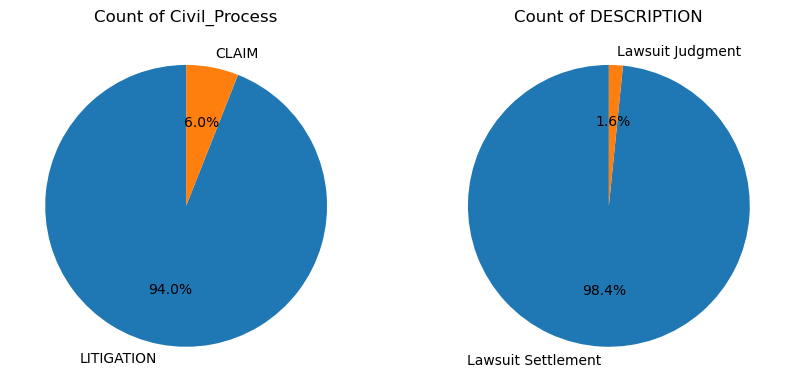

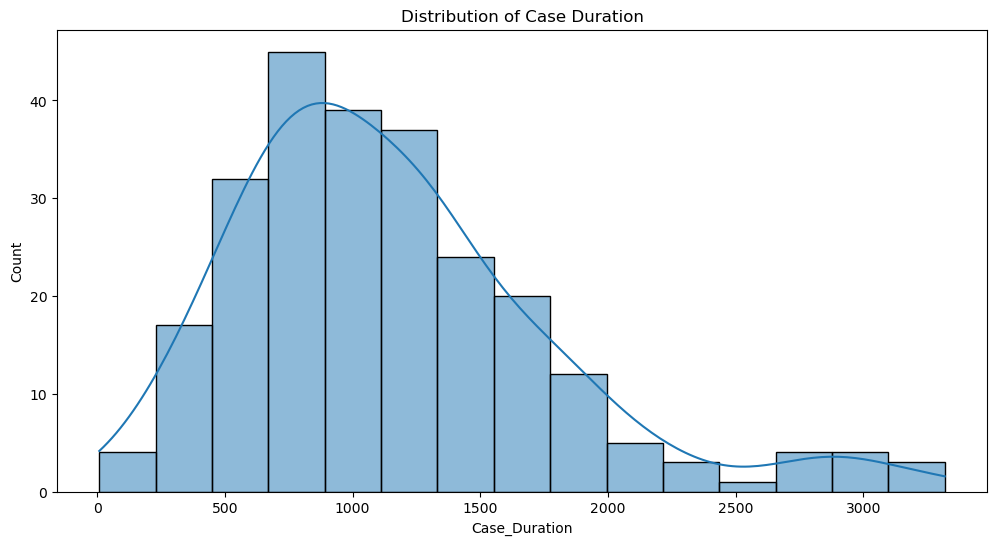

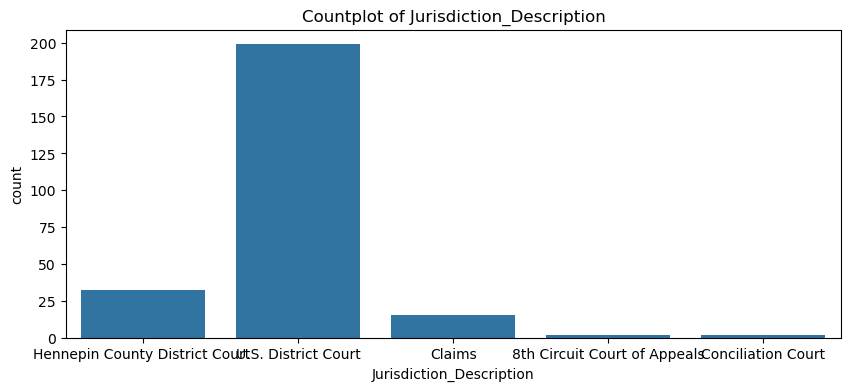

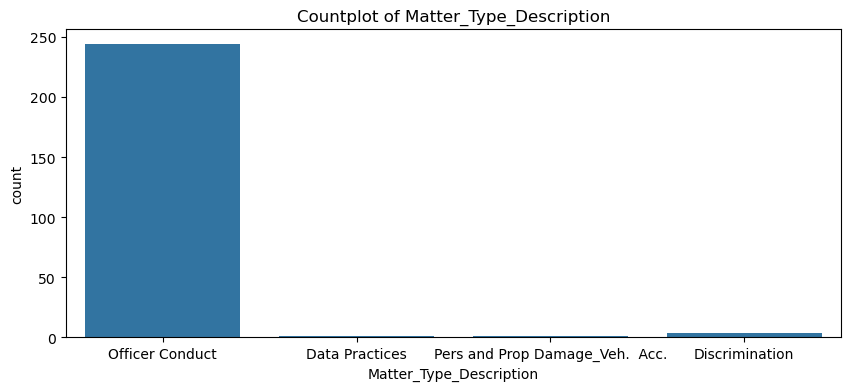

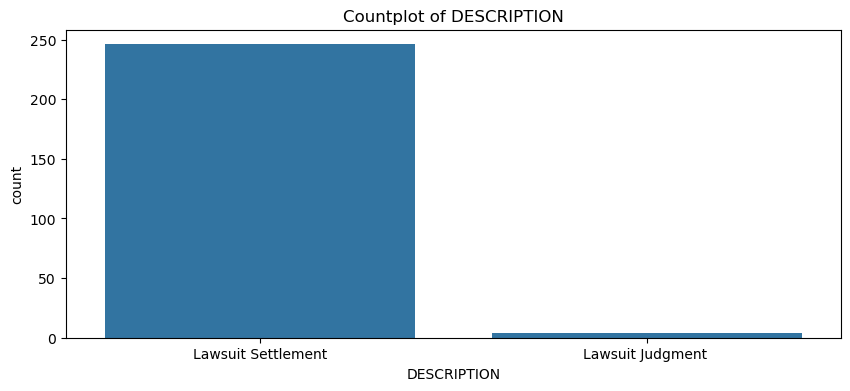

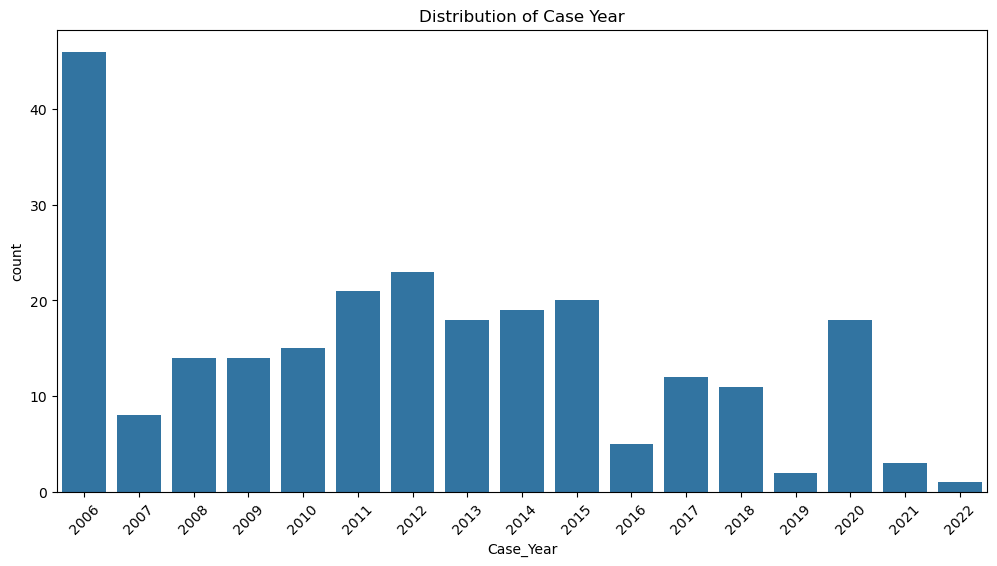

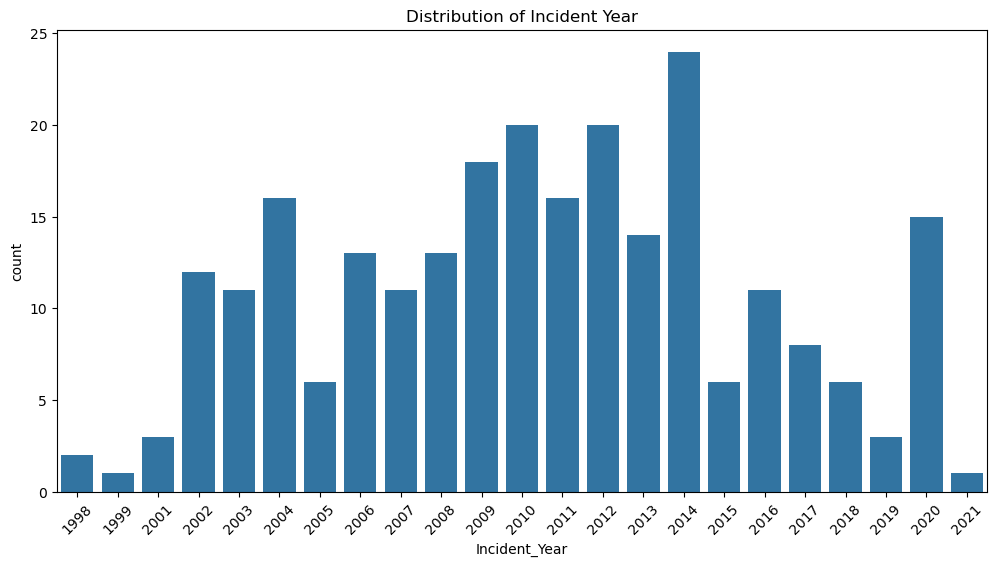

In [53]:
d_eda(df)

In [54]:
df['Officer_Name'].value_counts().sort_values(ascending=False).head(10)

Officer_Name
Robinson, Darryl Maurice                       3
McWhorter, Bernadine (Trustee:Bragg Burns)     3
Da                                             3
Crowder, Tiffany                               2
Labon, Malcolm                                 2
Simpson, John Emmett                           2
Wuchko, John                                   2
Lynch, Catrice                                 2
Kastner, Nicholas                              2
Stepnes, Paul                                  2
Name: count, dtype: int64